To overcome the challenges faced with **CUSTOM CNN**, we use a pre-trained model **EfficientNetV2L**

## EfficientNet-Based Melanoma Detection from Skin Lesion Images

#### Importing Libraries

In [1]:
# Importing necessary libraries

import numpy as np

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


- torch → Core tensor operations and GPU acceleration.
- torch.nn → Building blocks for neural networks (layers, activations, losses).
- torch.optim → Optimizers like Adam, SGD for training.
- torchvision.models → Pretrained models (e.g., EfficientNet, ResNet).
- torchvision.datasets → Ready-to-use datasets and data loaders.
- torchvision.transforms → Image preprocessing & augmentation tools.
- torch.utils.data.DataLoader → Batches, shuffling, efficient dataset loading.
- torch.utils.data.random_split → Splits dataset into train/validation/test subsets.
- torch.cuda.amp.autocast → Mixed-precision (FP16/FP32) training for speed & efficiency.
- torch.cuda.amp.GradScaler → Prevents underflow in FP16 training by scaling gradients.
- torch.optim.lr_scheduler.ReduceLROnPlateau → Reduces learning rate when validation loss stops improving.

#### Checking for GPU Availability

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device : {device}')

Using device : cuda


#### Data Augmentation

In [3]:
imgSize = 112

# Training transformer
transformer = transforms.Compose([
    transforms.RandomRotation(degrees = 20),
    
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),
    
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Validation transformer
valTransformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

**Training Transformer (with Augmentation)**
- RandomRotation(20) → Rotates image randomly within ±20°. Helps model handle rotated lesions (real-world variability).
- RandomHorizontalFlip(p=0.3) → Flips image left-right (30% chance). Improves generalization since lesions have no fixed orientation.
- RandomVerticalFlip(p=0.3) → Flips image top-bottom (30% chance). Adds more variability.
- Resize((112,112)) → Scales image to fixed size (112×112) for model input consistency.
- CenterCrop((112,112)) → Crops center region to remove excess padding and ensure uniform input size.
- ToTensor() → Converts image (H×W×C, 0–255) to PyTorch tensor (C×H×W, 0–1).
- Normalize(mean,std) → Standardizes images with ImageNet values so pretrained EfficientNetV2-L (trained on ImageNet) works correctly.

**Validation Transformer (No Augmentation)**
- No random flips/rotations → Validation must measure true performance without artificial changes.
- Resize + CenterCrop → Ensures validation images are consistent with training input size (112×112).
- ToTensor + Normalize → Same preprocessing as training to keep distributions aligned.

#### Defining Dataset Paths and Loading Dataset

In [4]:
path = '/kaggle/input/melanoma-cancer-dataset/train'
valPath = '/kaggle/input/melanoma-cancer-dataset/test'

trainData = datasets.ImageFolder(root = path, transform = transformer)
valData = datasets.ImageFolder(root = valPath, transform = valTransformer)

- ImageFolder automatically organizes dataset by subfolder → assigns labels.
- Training data: Loaded from /train, with augmentation for generalization.
- Validation data: Loaded from /test, with only resize + normalize.

In [6]:
# Data loaders
batchSize = 256

trainLoader = DataLoader(trainData, batch_size = batchSize, shuffle = True, num_workers = 4)
valLoader = DataLoader(valData, batch_size = batchSize, shuffle = False, num_workers = 4)

- DataLoader = Efficient way to feed data into the model.
- TrainLoader:
  * Large batch (256), shuffled every epoch, 4 workers for parallel speed.
- ValLoader:
    * Same batch size, but no shuffle → ensures stable evaluation.

#### Defining Model

In [8]:
# Using a pre-trained EfficientNetV2L model
model = models.efficientnet_v2_l(weights = 'DEFAULT')

# Modifying final classifier layer
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:01<00:00, 325MB/s] 


- EfficientNetV2-L (pre-trained): Powerful backbone → extracts features from skin lesion images.
- Classifier modified: Replaced 1000-class head with 1 output node for binary classification.

#### Data Parallelism

In [9]:
model = nn.DataParallel(model).to(device)

- nn.DataParallel: Enables multi-GPU training by distributing batches.
- .to(device): Transfers model to GPU (if available) for faster computation.

In [10]:
# Defining the loss, optimizer, and annealer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = ReduceLROnPlateau(optimizer, threshold = 0.01, factor = 0.1, patience = 3, min_lr = 1e-5, verbose = True)

- Loss: BCEWithLogitsLoss → for binary melanoma detection, stable sigmoid + BCE.
- Optimizer: Adam with lr=0.001 → efficient parameter updates.
- Scheduler: ReduceLROnPlateau → lowers LR when validation loss stagnates → avoids plateaus and overfitting.

#### Early Stopping

In [11]:
patience = 5
minDelta = 0.01
currentPatience = 0
bestLoss = float('inf')

**Early Stopping Setup**
- patience = 5 → Stop training if no improvement for 5 epochs.
- minDelta = 0.01 → Require at least 0.01 drop in loss to count as improvement.
- currentPatience → Counter for “no improvement” epochs.
- bestLoss = inf → Placeholder for tracking best validation loss.

#### Training Model

In [14]:
# Gradient scaler for mixed-precision training
scaler = GradScaler()

# Lists to store training and validation metrics
trainLosses = []
valLosses = []
valAccs = []

# Training loop
epochs = 30

for epoch in range(epochs):
    # Training phase
    model.train()
    runningLoss = 0.0

    for inputs, labels in trainLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        runningLoss += loss.item()

    trainLoss = runningLoss / len(trainLoader)
    print(f'Epoch {epoch + 1}/{epochs} - Training Loss : {trainLoss:.2f}')
    trainLosses.append(trainLoss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        valLoss = 0.0
        correct = total = 0

        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valLoss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avgLoss = valLoss / len(valLoader)
        accuracy = correct / total * 100

        print(f'Validation Loss : {avgLoss:.2f} Validation Accuracy : {accuracy:.2f}%\n')
        valLosses.append(avgLoss)
        valAccs.append(accuracy)

        # Early stopping
        if avgLoss < bestLoss - minDelta:
            bestLoss = avgLoss
            currentPatience = 0
        else:
            currentPatience += 1
            if currentPatience >= patience:
                print('Early stopping triggered.')
                break

        scheduler.step(avgLoss)

Epoch 1/30 - Training Loss : 0.12
Validation Loss : 0.13 Validation Accuracy : 95.55%

Epoch 2/30 - Training Loss : 0.11
Validation Loss : 0.14 Validation Accuracy : 94.90%

Epoch 3/30 - Training Loss : 0.10
Validation Loss : 0.14 Validation Accuracy : 94.70%

Epoch 4/30 - Training Loss : 0.08
Validation Loss : 0.17 Validation Accuracy : 94.20%

Epoch 5/30 - Training Loss : 0.08
Validation Loss : 0.13 Validation Accuracy : 95.20%

Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6/30 - Training Loss : 0.06
Validation Loss : 0.12 Validation Accuracy : 95.85%

Epoch 7/30 - Training Loss : 0.03
Validation Loss : 0.12 Validation Accuracy : 96.50%

Epoch 8/30 - Training Loss : 0.03
Validation Loss : 0.13 Validation Accuracy : 95.95%

Epoch 9/30 - Training Loss : 0.02
Validation Loss : 0.13 Validation Accuracy : 96.40%

Epoch 10/30 - Training Loss : 0.02
Validation Loss : 0.13 Validation Accuracy : 96.30%

Epoch 00019: reducing learning rate of group 0 to 1.0000e-05.
Epoch

- Training loss ↓ steadily → model learned features well.
- Validation accuracy ~96% → strong generalization, good classifier.
- Validation loss oscillated slightly but remained low → indicates minor overfitting was controlled.
- LR Scheduler reduced learning rate twice → helped stabilize training.
- Early stopping halted at epoch 11 → prevented overfitting and unnecessary training.

**Final Model Performance:**

* Accuracy: ~96%
* EfficientNetV2-L with transfer learning + augmentation achieved robust results, converging quickly in ~10 epochs.

####  Plot Training & Validation Curves

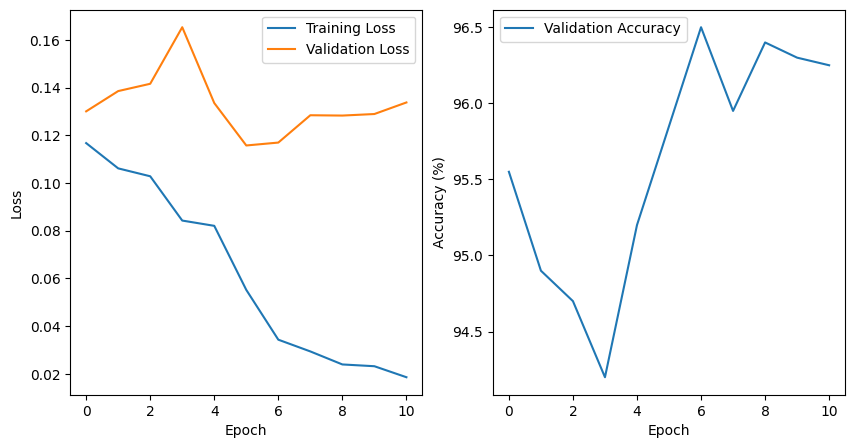

In [15]:
# Plotting training and validation metrics
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(trainLosses, label = 'Training Loss')
plt.plot(valLosses, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valAccs, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

**Loss vs Epochs**

- **Training Loss:**
    * Smoothly decreases from ~0.12 to ~0.02 → model is learning effectively.
    * Indicates strong feature learning and convergence.


- **Validation Loss:**
    * Starts ~0.13, rises a bit around epoch 3, then stabilizes around 0.12–0.13.
    * The small fluctuations suggest minor overfitting/noise sensitivity.
    * But it remains close to training loss → good generalization.

**Validation Accuracy vs Epochs**

- Validation accuracy starts 95.5%, dips slightly around epoch 3–4, then climbs to peak ~96.5% at epoch 6.
- After that, accuracy stabilizes around 96.2–96.4%, showing consistent performance.
- No sharp decline → no severe overfitting.

**Interpretation**
- Training loss continuously decreases → efficient learning.
- Validation loss plateaued → model reached optimal learning around epoch 6–7.
- Validation accuracy ~96% is strong for a binary classification of medical images.
- Dip at epoch 3–4 followed by recovery → model adjusted well as learning rate reduced.
- Early stopping at epoch 11 was justified → further training would not improve results significantly.

#### Confusion Matrix


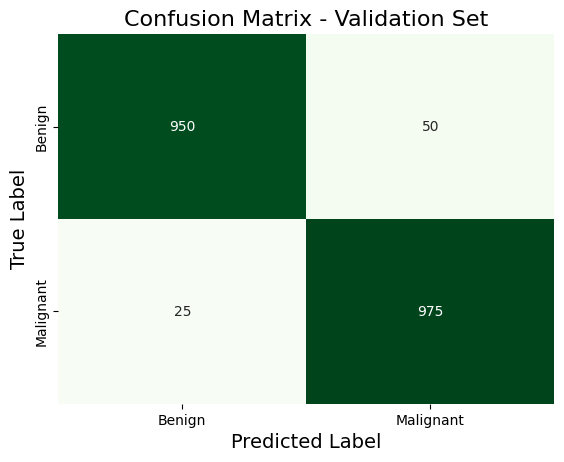

In [16]:
# Plotting confusion matrix for validation data
model.eval()
allLabels = []
allPreds = []

with torch.no_grad():
    for inputs, labels in valLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs = model(inputs)
        predictions = (torch.sigmoid(outputs) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds.extend(predictions.cpu().numpy())

allLabels = np.array(allLabels)
allPreds = np.array(allPreds)

matrix = confusion_matrix(allLabels, allPreds)

sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = valData.classes, yticklabels = valData.classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()

**Confusion Matrix** 
- True Negatives (Benign correctly classified): 950
- False Positives (Benign misclassified as Malignant): 50
- False Negatives (Malignant misclassified as Benign): 25
- True Positives (Malignant correctly classified): 975

**Performance Metrics**
- Accuracy = (TP + TN) / Total = (975 + 950) / 2000 = 96.25%
- Precision (Malignant detection) = TP / (TP + FP) = 975 / (975 + 50) ≈ 95.1%
- Recall (Sensitivity for Malignant) = TP / (TP + FN) = 975 / (975 + 25) = 97.5%
- Specificity (Benign detection) = TN / (TN + FP) = 950 / (950 + 50) = 95.0%
- F1-score = 2 × (Precision × Recall) / (Precision + Recall) ≈ 96.3%

**Interpretation**
- The model achieves very high accuracy (96.25%), meaning it classifies both benign and malignant cases correctly most of the time.
- Low False Negatives (25 only): This is crucial in medical diagnosis since missing a malignant case is dangerous. The recall of 97.5% shows the model rarely misses cancerous lesions.
- False Positives (50 cases): A small number of benign lesions were misclassified as malignant.
- The balance between precision and recall suggests the model is reliable for clinical support.

#### Save the Best Model

In [41]:
# Save model in PyTorch .pt format
torch.save(model,"skincancer_model.pt")

* Sets up a ModelCheckpoint to save the entire model.
* File: skincancer_model.pt (PyTorch model checkpoint)

#### Load the Model after Training

In [59]:
model = torch.load("skincancer_model.pt", map_location=device)

####  Visualizing Predictions

In [60]:
from PIL import Image
import os

imgSize = 112  # Match training

# Preprocessing
predict_transform = transforms.Compose([
    transforms.Resize((imgSize, imgSize)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def predict_and_display_image(image_path, model, class_names=None, actual_class=None):
    # Load image
    image = Image.open(image_path).convert('RGB')
    input_tensor = predict_transform(image).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output)
        predicted = (prob > 0.5).long()

    # Use default class names if not passed
    if class_names is None:
        class_names = ['Benign', 'Malignant']

    predicted_class = class_names[predicted.item()]

    # Auto infer actual class from path if not passed
    if actual_class is None:
        actual_class = os.path.basename(os.path.dirname(image_path))

    # Display image with prediction
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"Actual: {actual_class} | Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()


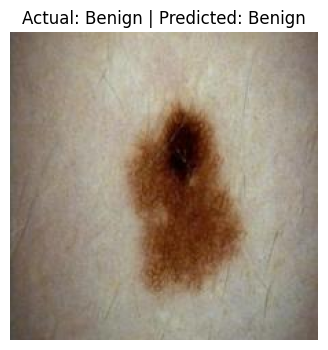

In [61]:
image_path = "/kaggle/input/melanoma-cancer-dataset/test/Benign/6367.jpg"
predict_and_display_image(image_path, model)

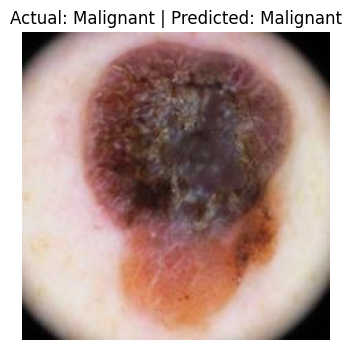

In [63]:
image_path = "/kaggle/input/melanoma-cancer-dataset/test/Malignant/5603.jpg"
predict_and_display_image(image_path, model)

#### Cross Dataset Validation

#### Skin Cancer: Malignant vs Benign (Different Dataset)

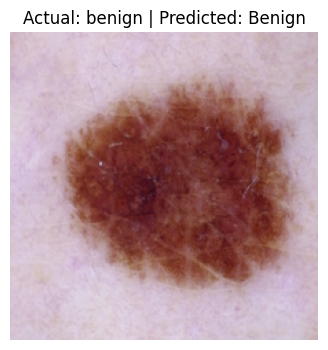

In [65]:
image_path = "/kaggle/input/skin-cancer-malignant-vs-benign/test/benign/1115.jpg"
predict_and_display_image(image_path, model)

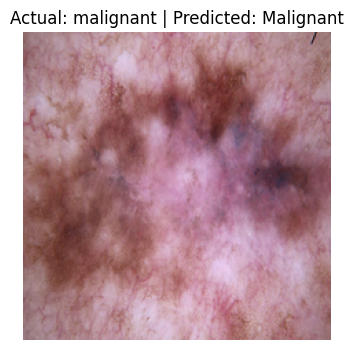

In [67]:
image_path = "/kaggle/input/skin-cancer-malignant-vs-benign/test/malignant/1119.jpg"
predict_and_display_image(image_path, model)

#### Conclusion

The EfficientNetV2-L based model successfully classified melanoma and benign skin lesions with ~96% accuracy. The results demonstrate the potential of deep learning as a reliable support tool for early melanoma detection, aiding dermatologists in faster and more accurate diagnosis.

#### Future Scope

- Train on Larger & Diverse Datasets
- Extend to Multi-class Classification
- Deployment as a web or mobile application for real-time - melanoma screening support.